In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


C:\Users\mgalib\AppData\Local\Temp\ipykernel_8024\235436283.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-94.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  LAG.loc[file+".csv"] = Lag_time


ValueError: Axis limits cannot be NaN or Inf

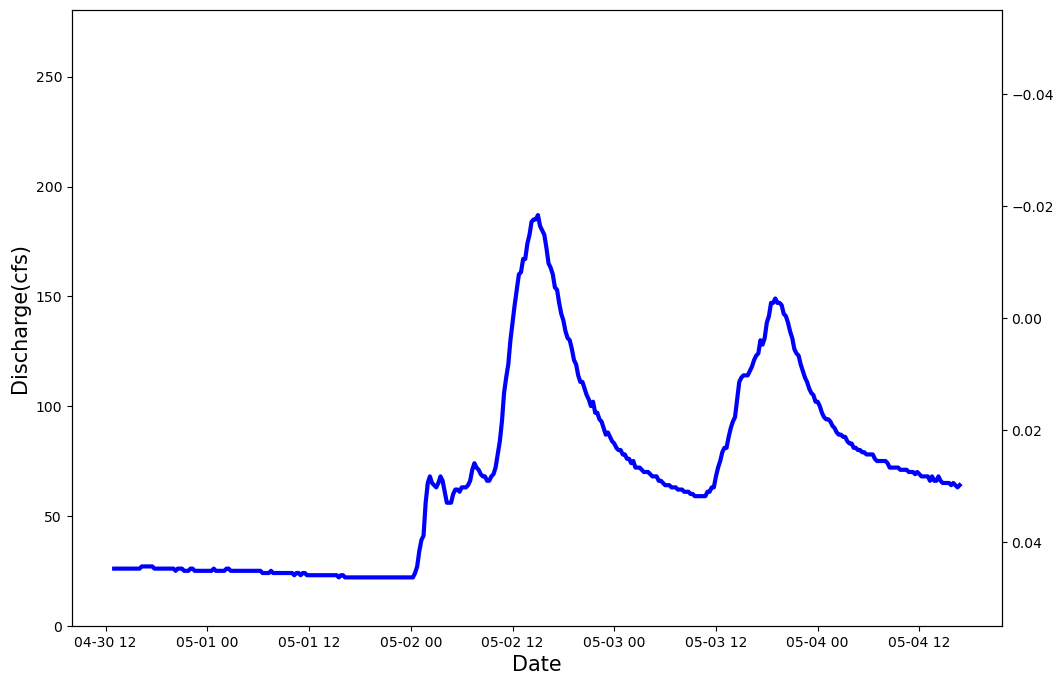

In [5]:
# function to create a folder to store the results if it does not exist

def ResultsFolder(Folder):
    if os.path.exists(Folder) == False:
        os.mkdir(Folder)

# create a corresponding folder for lag times file and rainfall-runoff event figures
# obtain the file name of the flood event(.csv)


direct = 'C:/Users/mgalib/Box/Finley_UH_work/Data/TN'
# Assuming 'direct' is defined somewhere above this snippet as your base directory path
Folder1 = os.path.join(direct, 'lag_time')
ResultsFolder(Folder1)  # 



# obtain the file name of the flood event(.csv)

rawdata_folder = 'C:/Users/mgalib/Box/Finley_UH_work/Data/TN/rainfall-runoff-events_TN/'
filename = os.listdir(rawdata_folder)

# create a dataframe to store lag time of all the rainfall-runoff events

LAG = pd.DataFrame(0, index=filename,columns=['Lag time_hr'])
LAG.index.name = 'File_Name'

for file in filename:
    # read the data
    Data = pd.read_csv(rawdata_folder + file,parse_dates=['Date1','Date_2'])

    file = file.split(".")[0]

    date1=pd.to_datetime(Data.Date1).dt.tz_localize(None)
    y1=Data.Discharge_cfs

    date2=Data.Date_2
    date2=date2.dropna()
    y2=Data.Rainfall_in
    y2=y2.dropna()

    # SCS Curve Number Method FOR ABSTRACTIONS
    CN = Data.CN[0]

    # potential maximum retention
    S = 1000/CN-10

    # total rainfall (in/15min)
    P = y2.sum()

    # initial abstraction
    Ia = 0.2*S

    index_Ia = 0

    for i in range(len(y2)):
        Ia = Ia - y2[i]
        if Ia <= 0:
            index_Ia = i
            break

    # calculate the excess rainfall
    Pe = (P-Ia)**2/(P-Ia+S)
    # for visualization purposes
    y2=y2*Pe/P

    # obtain the peak discharge and the peak time
    Q_peak = Data.iloc[:,1].max()
    T_peak = date1[Data.iloc[:,1]==Q_peak]

    # obtain the duration of the excess rainfall
    D_rain = date2.iloc[-1]-date2.iloc[index_Ia]

    # calculate the lag time (in hours)

    Lag_time = (T_peak.iloc[0]-date1.iloc[index_Ia]-D_rain/2).days*24+(T_peak.iloc[0]-date1.iloc[index_Ia]-D_rain/2).seconds/3600
    LAG.loc[file+".csv"] = Lag_time

    fig, ax1 = plt.subplots(figsize=(12,8))
    ax1.plot(date1, y1,color='blue',label="Runoff",linewidth = 3)

    ax1.set_ylim(0, max(y1)*1.5)
    ax1.set_xlabel("Date",fontsize=15)
    ax1.set_ylabel("Discharge(cfs)",fontsize=15)

    ax2 = ax1.twinx()
    ax2.bar(date2, y2,color='red',label="Rainfall",width=0.05)

    ax2.invert_yaxis()
    ax2.set_ylim(max(y2)+0.1, 0)
    ax2.set_ylabel("Rainfall(in)",fontsize=15)

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1+handles2, labels1+labels2,loc='best',edgecolor='k',fontsize=15)

    plt.title("Rainfall-Runoff Event of " + file,fontsize=15)

    #plt.savefig(Folder1 + "Rainfall-Runoff Event of " + file + ".jpeg")
    plt.close()

# save the lag time of all the runoff events as CSV in the "UH" folder
csv_file_path = os.path.join(Folder1, "Lag Time of Watersheds.csv")
LAG.to_csv(csv_file_path)


print("Lag time processing is done!")


In [8]:
import pandas as pd
import os
from datetime import timedelta
import matplotlib.pyplot as plt

def ResultsFolder(Folder):
    if not os.path.exists(Folder):
        os.makedirs(Folder)

# Define directories and create necessary folders
direct = 'C:/Users/mgalib/Box/Finley_UH_work/Data/TN'
Folder1 = os.path.join(direct, 'lag_time')
ResultsFolder(Folder1)

rawdata_folder = os.path.join(direct, 'rainfall-runoff-events_TN')
filename = os.listdir(rawdata_folder)

# DataFrame to store lag time for all events
LAG = pd.DataFrame(index=filename, columns=['Lag time_hr'])
LAG.index.name = 'File_Name'

for file in filename:
    try:
        # Read the event data
        Data = pd.read_csv(os.path.join(rawdata_folder, file), parse_dates=['Date1', 'Date_2'])
        Data.dropna(subset=['Date1', 'Date_2', 'Rainfall_in'], inplace=True)

        date1 = pd.to_datetime(Data['Date1']).dt.tz_localize(None)
        y1 = Data['Discharge_cfs']
        date2 = pd.to_datetime(Data['Date_2']).dt.tz_localize(None)
        y2 = Data['Rainfall_in']

        # SCS Curve Number Method for Abstractions
        CN = Data['CN'].iloc[0]  # Assuming CN is constant per file
        S = 1000 / CN - 10
        P = y2.sum()
        Ia = 0.2 * S

        # Calculate the index where initial abstraction is exceeded
        cumulative_rainfall = y2.cumsum()
        index_Ia = cumulative_rainfall[cumulative_rainfall >= Ia].index.min()

        if pd.isna(index_Ia):
            print(f"Initial abstraction not exceeded in {file}")
            continue

        # Excess rainfall calculation
        Pe = max((P - Ia) ** 2 / (P - Ia + S), 0)
        y2 = y2 * Pe / P  # Adjust rainfall data

        # Peak discharge time
        Q_peak = y1.max()
        T_peak = date1[y1 == Q_peak].iloc[0]

        # Duration of excess rainfall
        D_rain = date2.iloc[-1] - date2.iloc[index_Ia]

        # Calculate the lag time in hours
        Lag_time = (T_peak - date2.iloc[index_Ia] - D_rain / 2).total_seconds() / 3600
        LAG.loc[file] = Lag_time

        # Plotting
        fig, ax1 = plt.subplots(figsize=(12, 8))
        ax1.plot(date1, y1, color='blue', label="Runoff", linewidth=3)
        ax2 = ax1.twinx()
        ax2.bar(date2, y2, color='red', label="Rainfall", width=0.05)

        ax1.set_xlabel("Date")
        ax1.set_ylabel("Discharge (cfs)", color='blue')
        ax2.set_ylabel("Rainfall (in)", color='red')
        ax2.invert_yaxis()

        plt.title("Rainfall-Runoff Event of " + file)
        plt.legend()
        plt.savefig(os.path.join(Folder1, f"Rainfall-Runoff Event of {file}.jpeg"))
        plt.close()
        
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Save the lag times
csv_file_path = os.path.join(Folder1, "Lag Time of Watersheds.csv")
LAG.to_csv(csv_file_path)

print("Lag time processing is done!")


Initial abstraction not exceeded in Event_3430147_2004-04-25.csv
Initial abstraction not exceeded in Event_3430147_2004-04-26.csv
Initial abstraction not exceeded in Event_3430147_2004-05-24.csv
Initial abstraction not exceeded in Event_3435970_2002-04-27.csv
Error processing Event_3486311_2004-05-24.csv: single positional indexer is out-of-bounds
Error processing Event_3486311_2004-06-18.csv: single positional indexer is out-of-bounds
Initial abstraction not exceeded in Event_3595100_2002-07-16.csv
Lag time processing is done!
